<a href="https://colab.research.google.com/github/donny95/py_d_on/blob/main/Bike_sharing_fbprophet_neural_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import


In [1]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
# from neuralprophet import NeuralProphet
from fbprophet.plot import add_changepoints_to_plot
import warnings
import datetime
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 데이터 불러오기

In [2]:
df = pd.read_csv("/content/drive/MyDrive/bike_share_prediction_London/data/london_merged.csv")

In [3]:
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [6]:
#object형인 timestamp을 날짜 데이터로 바꾸고 index를 날짜로 설정

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")

df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [7]:
#index의 날짜 정보를 이용하여 시간, 월, 주 등의 컬럼을 생성

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


# 시각화



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

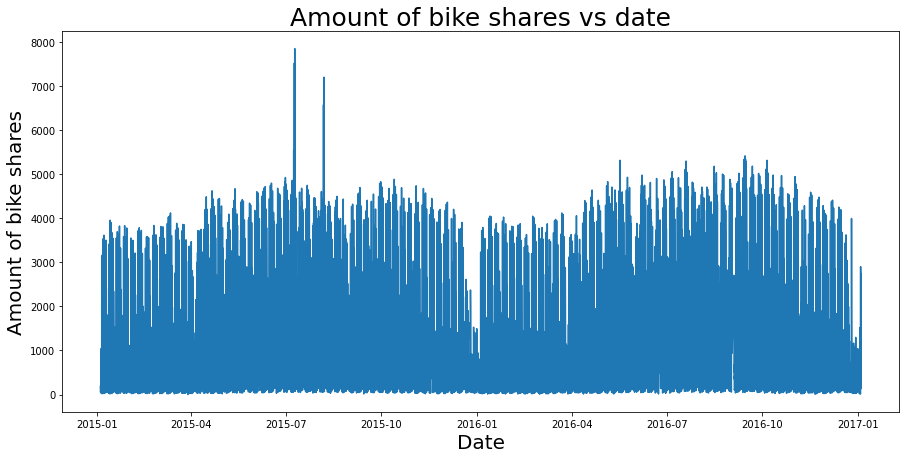

In [9]:
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x=df.index, y=df.cnt,data=df)
ax.set_title("Amount of bike shares vs date", fontsize=25)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel('Amount of bike shares', fontsize=20)
plt.show()

#prophet

In [10]:
data = pd.read_csv("/content/drive/MyDrive/bike_share_prediction_London/data/london_merged.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"])

mydata = data[['timestamp', 'cnt']].copy()
mydata["timestamp"] = pd.to_datetime(mydata["timestamp"])
mydata = mydata.set_index("timestamp")
mydata

,cnt
timestamp,
2015-01-04 00:00:00,182
2015-01-04 01:00:00,138
2015-01-04 02:00:00,134
2015-01-04 03:00:00,72
2015-01-04 04:00:00,47
...,...
2017-01-03 19:00:00,1042
2017-01-03 20:00:00,541
2017-01-03 21:00:00,337


In [11]:
# Daily resampling
daydata = mydata.resample("D").sum()
daydata

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601
...,...
2016-12-30,11566
2016-12-31,11424
2017-01-01,6421


In [12]:
daydata['timestamp'] = daydata.index
daydata.index = range(0,len(daydata['cnt'].to_numpy()))
daydata

,cnt,timestamp
0,9234,2015-01-04
1,20372,2015-01-05
2,20613,2015-01-06
3,21064,2015-01-07
4,15601,2015-01-08
...,...,...
726,11566,2016-12-30
727,11424,2016-12-31
728,6421,2017-01-01
729,11823,2017-01-02


In [13]:
# No resampling for hourly prediction
hourdata = mydata
hourdata['timestamp'] = hourdata.index
hourdata.index = range(0,len(hourdata['cnt'].to_numpy()))
hourdata

,cnt,timestamp
0,182,2015-01-04 00:00:00
1,138,2015-01-04 01:00:00
2,134,2015-01-04 02:00:00
3,72,2015-01-04 03:00:00
4,47,2015-01-04 04:00:00
...,...,...
17409,1042,2017-01-03 19:00:00
17410,541,2017-01-03 20:00:00
17411,337,2017-01-03 21:00:00
17412,224,2017-01-03 22:00:00


In [14]:
daydf = daydata[['timestamp','cnt']].copy()
daydf.columns = ['ds','y']

hourdf = hourdata[['timestamp','cnt']].copy()
hourdf.columns = ['ds', 'y']

In [15]:
display(daydf)
display(hourdf)

,ds,y
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
726,2016-12-30,11566
727,2016-12-31,11424
728,2017-01-01,6421
729,2017-01-02,11823


,ds,y
0,2015-01-04 00:00:00,182
1,2015-01-04 01:00:00,138
2,2015-01-04 02:00:00,134
3,2015-01-04 03:00:00,72
4,2015-01-04 04:00:00,47
...,...,...
17409,2017-01-03 19:00:00,1042
17410,2017-01-03 20:00:00,541
17411,2017-01-03 21:00:00,337
17412,2017-01-03 22:00:00,224


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from fbprophet import Prophet

# Train the models
daymodel = Prophet()
hourmodel = Prophet()

# Fit the model with train set
daymodel.fit(daydf) 
hourmodel.fit(hourdf)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
dayfuture = daymodel.make_future_dataframe(periods=365)
hourfuture = hourmodel.make_future_dataframe(periods=365, freq='H')

daypred = daymodel.predict(dayfuture)
hourpred = hourmodel.predict(hourfuture)

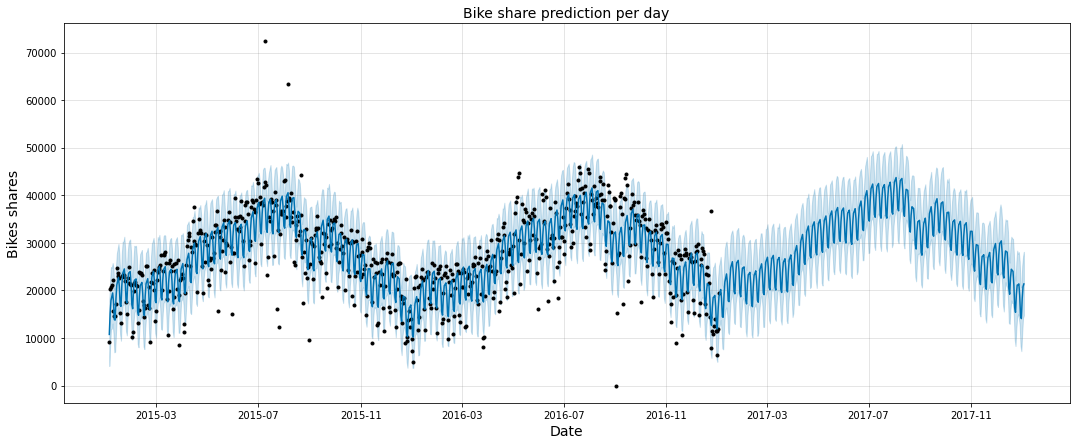

In [18]:
# Plot the day forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

daymodel.plot(daypred, ax=ax)

ax.set_title('Bike share prediction per day', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Bikes shares', fontsize=14)

plt.show()

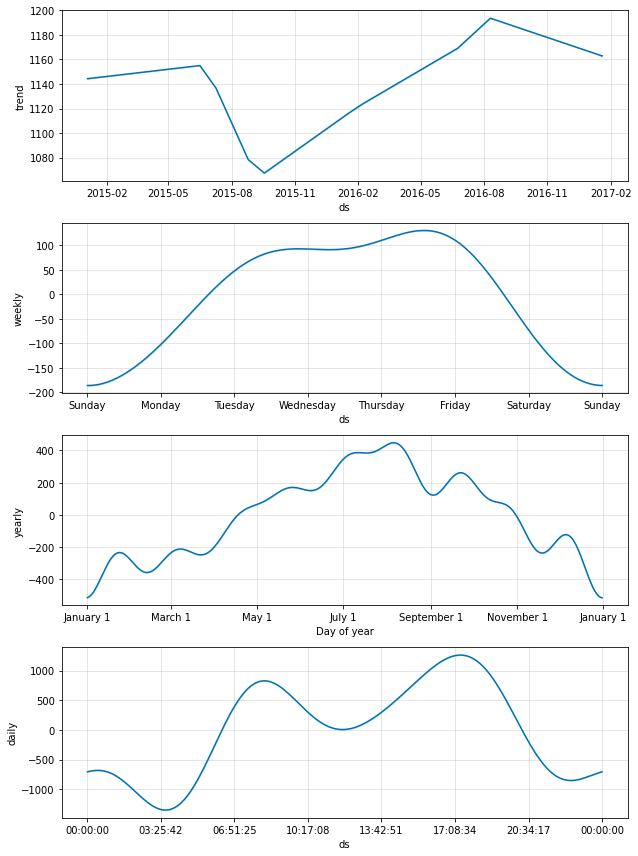

In [19]:
#plot_components_plotly(hourmodel, hourpred)
fig = hourmodel.plot_components(hourpred)

#neural prophet

In [20]:
# !pip install neuralprophet
from neuralprophet import NeuralProphet

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 748.8MB 13kB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [21]:
neuraldaymodel = NeuralProphet()
metrics = neuraldaymodel.fit(daydf, freq='D')

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 43
INFO:nprophet.config:Auto-set epochs to 43


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-03
INFO:nprophet:learning rate range test found optimal lr: 5.34E-03
Epoch[43/43]: 100%|██████████| 43/43 [00:06<00:00,  6.42it/s, SmoothL1Loss=0.00643, MAE=3.93e+3, RegLoss=0]


에폭이 충분히 돌지 않는 것을 확인

In [22]:
neuralhourmodel = NeuralProphet()
hourmetrics = neuralhourmodel.fit(hourdf, freq='H')

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s, SmoothL1Loss=0.0199, MAE=452, RegLoss=0]


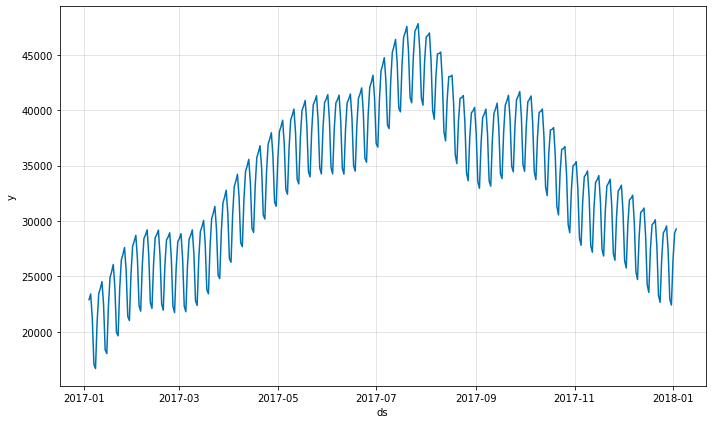

In [23]:
neuralhourfuture = neuralhourmodel.make_future_dataframe(hourdf, periods=365)
neuralhourforecast = neuralhourmodel.predict(neuralhourfuture)

neuraldayfuture = neuraldaymodel.make_future_dataframe(daydf, periods=365)
neuraldayforecast = neuraldaymodel.predict(neuraldayfuture)

dayforecasts_plot = neuraldaymodel.plot(neuraldayforecast)

# 결론 

- 페이스북의 prophet model을 쓰기 위해서는 충분한 양의 데이터 셋이 필요하다

참조 : https://www.kaggle.com/maartenvandevelde/london-bike-share-prophet-xgb-lstm/log#-3.-Prophet